# Clustering

In [87]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, pairwise_distances

import umap
from sklearn.cluster import KMeans

## Data Exploration

In [20]:
data_df = pd.read_excel('cc_info.xlsx')
data_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [21]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

## Data Cleaning

In [22]:
# How many are null values
data_df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [23]:
# It can be seen that some of the minimum payment values are NaNs. We set these to 0
data_df.loc[data_df['MINIMUM_PAYMENTS'].isnull(), 'MINIMUM_PAYMENTS']=0

In [24]:
# One of the credit limit value is a NaN. Since this is just 1 out of 8950 values, we simply remove the row
data_df = data_df[~data_df['CREDIT_LIMIT'].isnull()]

In [25]:
# Check for any duplicate customer IDs - None exist, so we are all good!
print('The number of unique Customer IDs are ' + str(len(data_df.CUST_ID.unique())))
# Set the CUST_ID as index
data_df = data_df.set_index('CUST_ID')

The number of unique Customer IDs are 8949


## Feature Exploration

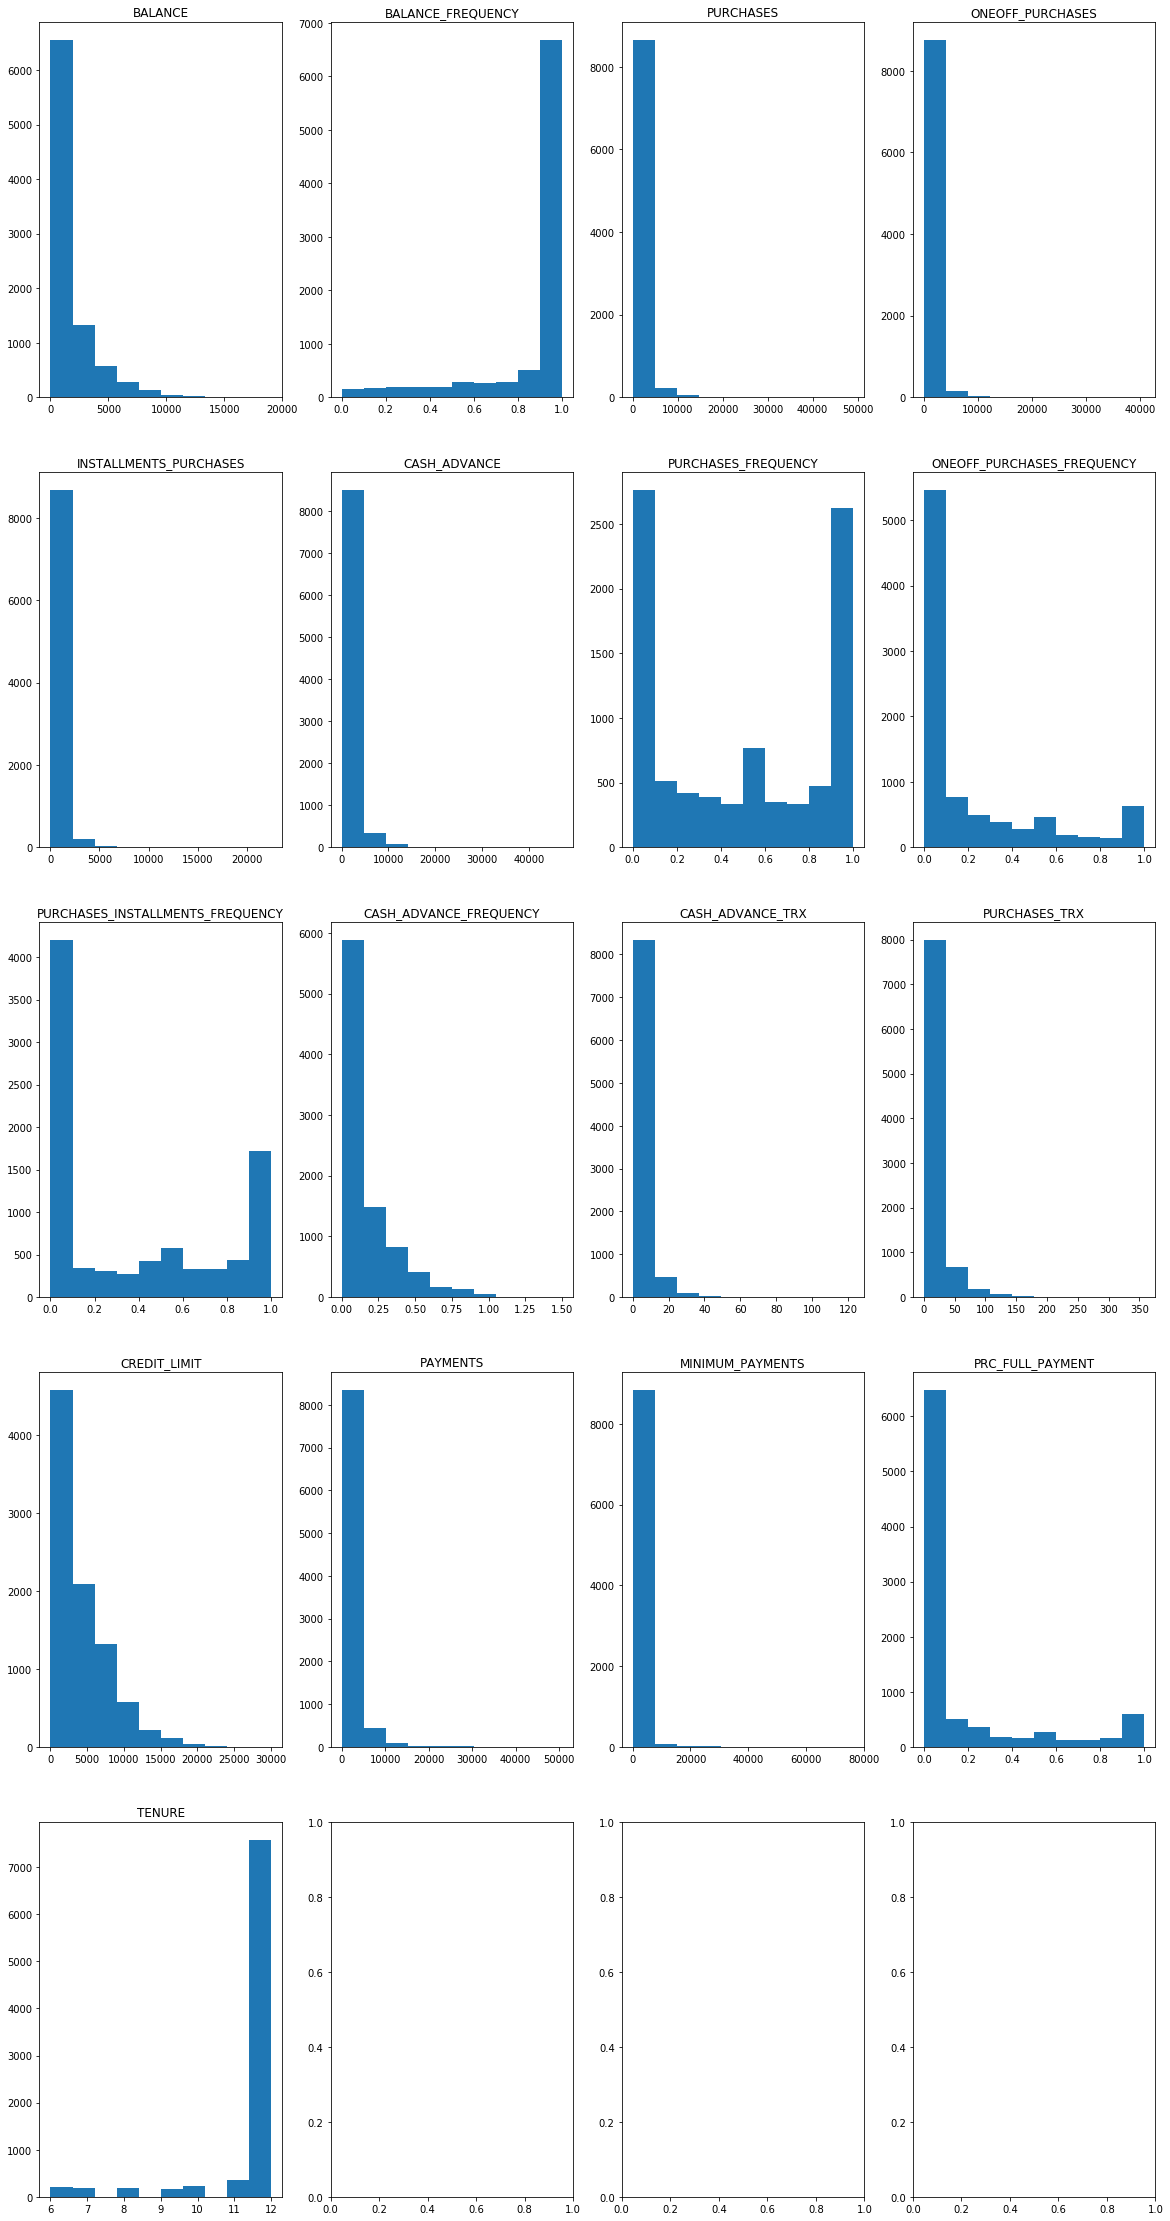

In [26]:
# Plot histograms of all variables to see the distribution of values
fig, axes = plt.subplots(5,4, figsize=[20, 40])
for ii,vv in enumerate(data_df.columns):
    r = (ii//4)
    c = np.mod(ii,4) 
    axes[r,c].hist(data_df[vv])
    axes[r,c].set_title(vv)
    axes[r,c].grid(b=True)

In [27]:
data_df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [28]:
# Convert cash-variables to log
variables_to_log = ['BALANCE','PURCHASES', 'ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', \
                   'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']
for col in variables_to_log:
    data_df[col] = np.log10(data_df[col]+1)

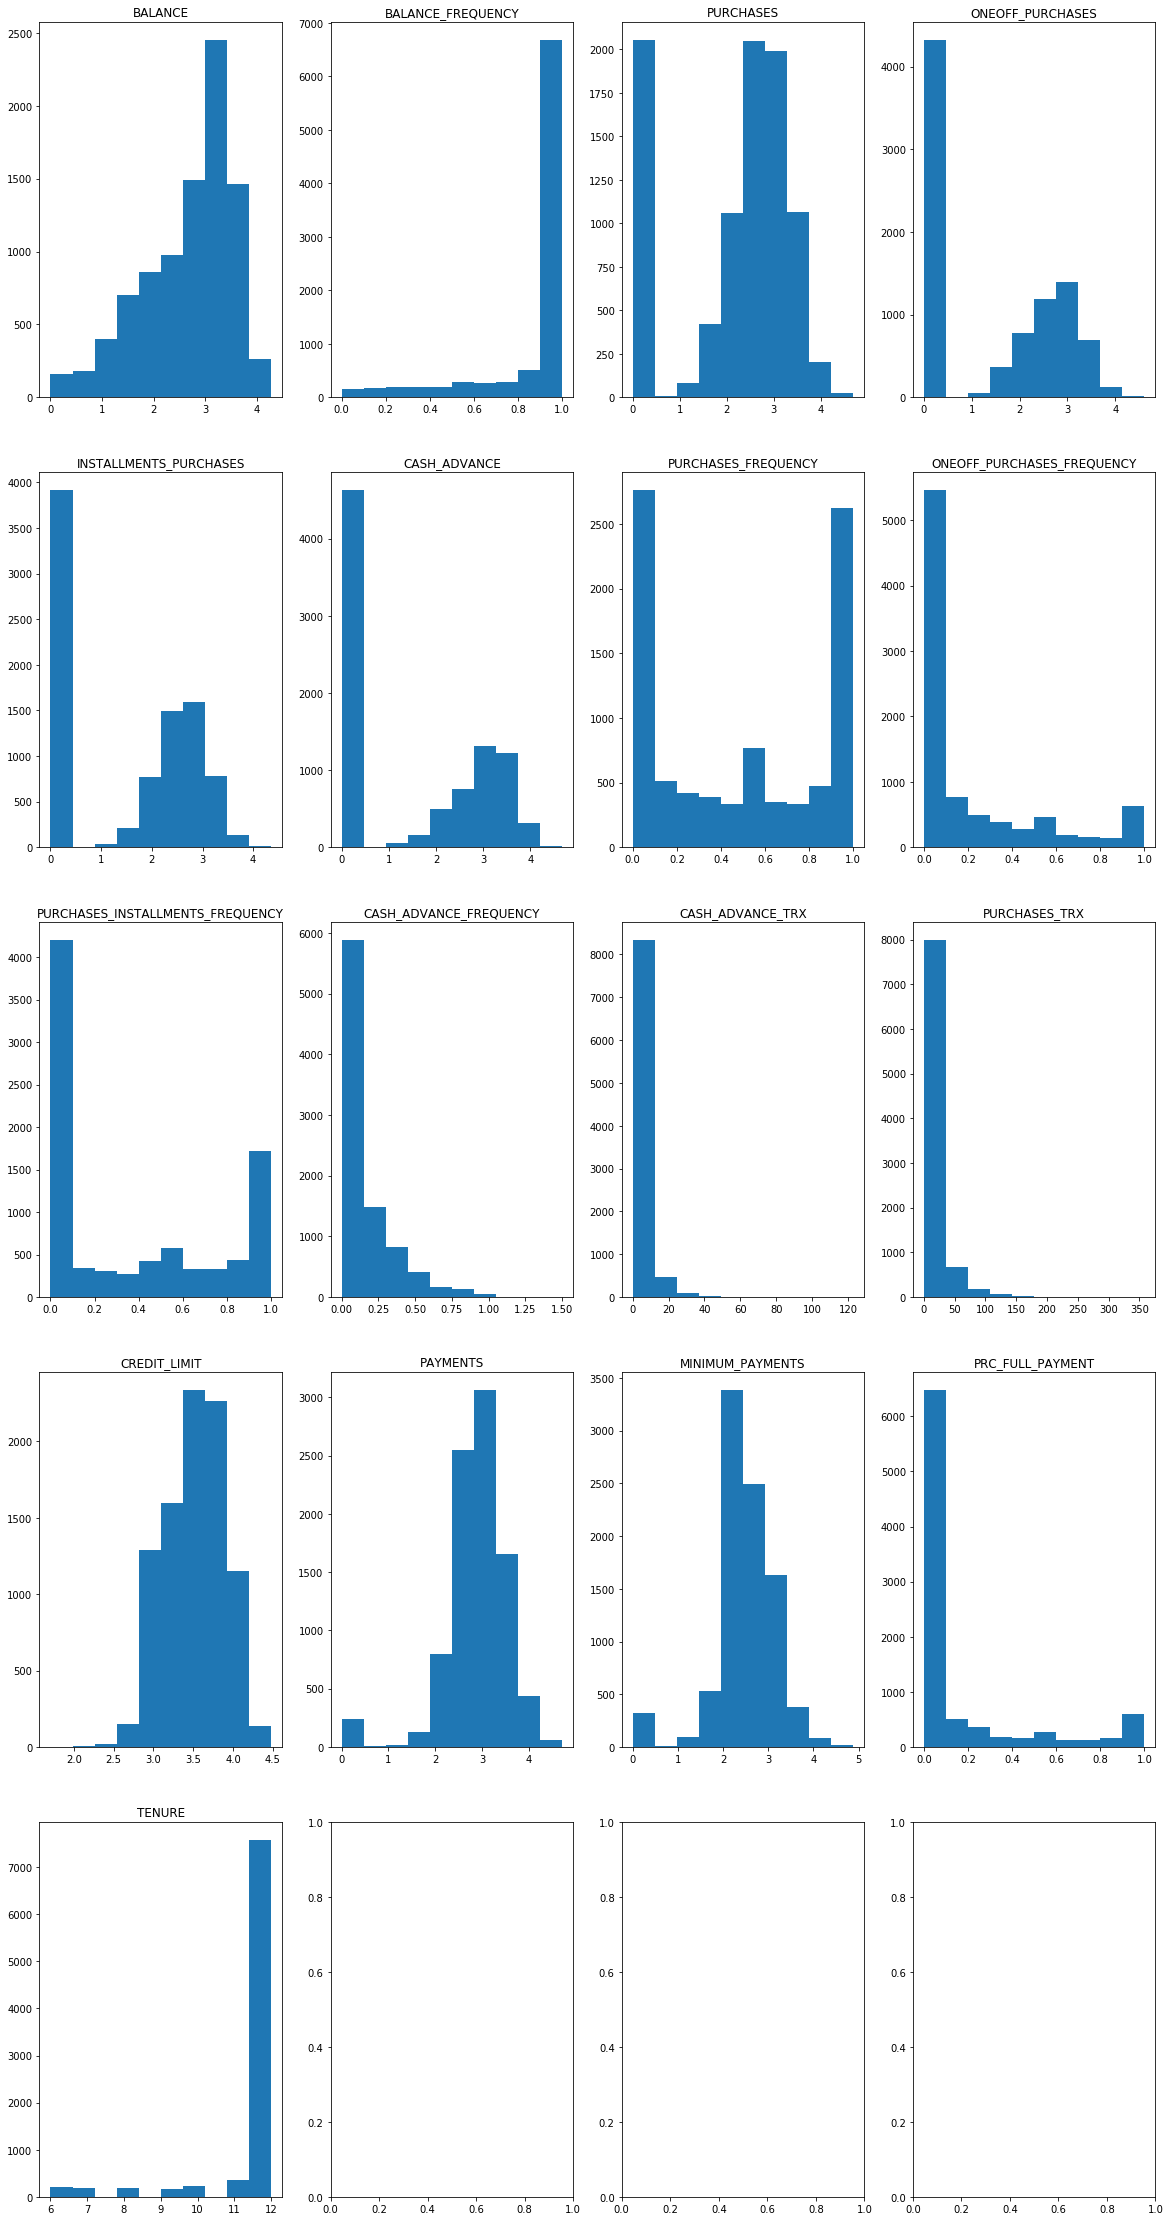

In [29]:
# Plot histograms of all variables to see the distribution of values
fig, axes = plt.subplots(5,4, figsize=[20, 40])
for ii,vv in enumerate(data_df.columns):
    r = (ii//4)
    c = np.mod(ii,4) 
    axes[r,c].hist(data_df[vv])
    axes[r,c].set_title(vv)
    axes[r,c].grid(b=True)

Some of the distributions are normal (e.g. Balances). Some others are normal except for component at zero (e.g. Purchases). For the former, we can apply normal scaling. For the latter, we can apply normal scaling to all non-zero values (i.e. by finding variance and mean for non-zero values) and keep zero values as such. But for simplicity, here we just do a min-max scaling for all.

In [31]:
data_df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [33]:
# Apply Min-max scalar
min_max_features = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE']
for col in min_max_features:
    data_df[col] = MinMaxScaler().fit_transform(data_df[col].to_numpy().reshape(-1,1))

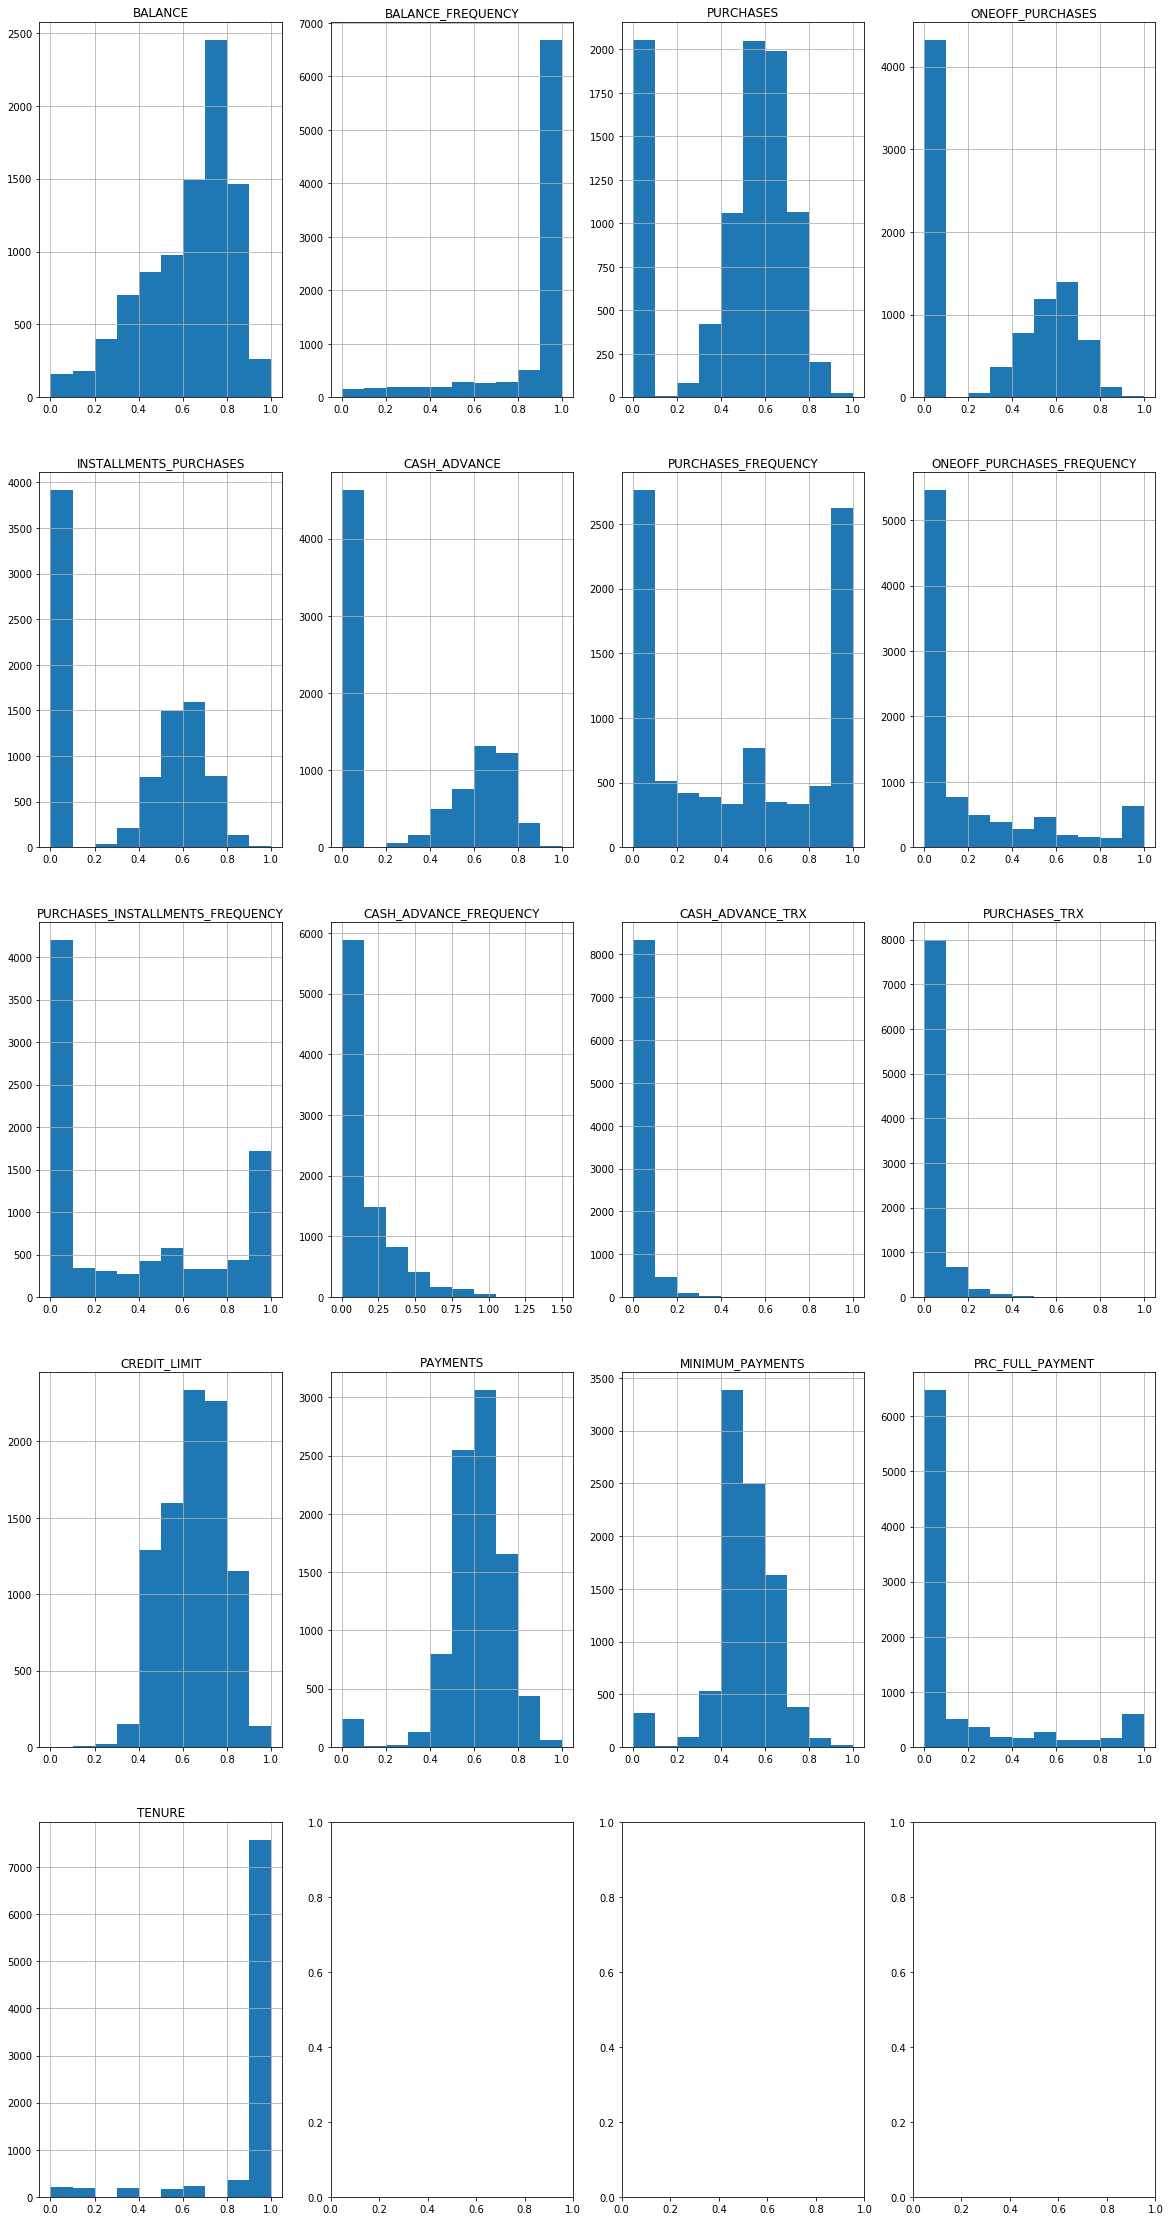

In [62]:
# Plot histograms of all variables to see the distribution of values
fig, axes = plt.subplots(5,4, figsize=[20, 40])
for ii,vv in enumerate(data_df.columns):
    r = (ii//4)
    c = np.mod(ii,4) 
    axes[r,c].hist(data_df[vv])
    axes[r,c].set_title(vv)
    axes[r,c].grid(b=True)

## Dimensionality Reduction

For dimension reduction, we'll use UMAP (Uniform Manifold Approximation and Projection). Unlike PCA, UMAP is a non-linear technique. Unlike t-SNE (t-distributed stochastic neighbor embedding), UMAP does a better job preserving global structure. UMAP also has the handy feature that, by default, it reduces the data to two dimensions, which is good for visualization.

In [38]:
data_df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,0.379045,0.818182,0.422994,0.000000,0.455879,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.466811,0.490324,0.439821,0.000000,1.0
C10002,0.819116,0.909091,0.000000,0.000000,0.000000,0.815075,0.000000,0.000000,0.000000,0.250000,0.03252,0.000000,0.771814,0.767919,0.620654,0.222222,1.0
C10003,0.793799,1.000000,0.615884,0.626611,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.782631,0.593925,0.573025,0.000000,1.0
C10004,0.752871,0.636364,0.677125,0.688918,0.000000,0.495472,0.083333,0.083333,0.000000,0.083333,0.00813,0.002793,0.782631,0.000000,0.000000,0.000000,1.0
C10005,0.680676,1.000000,0.262325,0.266894,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.495375,0.601905,0.489556,0.000000,1.0


In [39]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data_df)
embedding.shape

(8949, 2)

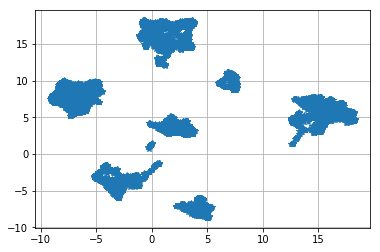

In [42]:
# Plot the clusters
plt.figure()
plt.plot(embedding[:,0], embedding[:,1], '*')
plt.grid(b=True)
plt.show()

Straightforward way to cluster this is to just use K-means of 7 on above prohection

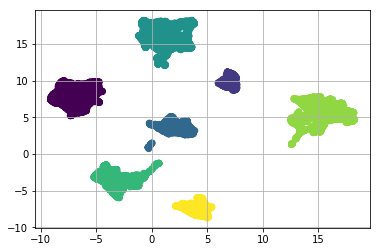

In [44]:
model = KMeans(n_clusters=7, random_state=0)
labels = model.fit_predict(embedding)

plt.figure()
plt.scatter(embedding[:, 0],  embedding[:, 1], c = labels)
plt.grid(b=True)
plt.show()

# Visualize Different Clusters

In [66]:
# Function to visualize distribution of feature values for different clusters
def visualize_feature_boxplot_for_clusters(X, cluster_labels):
    """
    X is a Pandas dataframe with num-samples X num-features
    cluster_labels is an array of labels for each sample.
    """
    # Plot histograms for each of the variables
    Y = X.copy()
    Y['Class']= cluster_labels
    
    num_features = len(X.columns)
    fig, axes = plt.subplots(num_features//3 + 1,3, figsize=[20, 40])
    for ii,vv in enumerate(data_df.columns):
        r = (ii//3)
        c = np.mod(ii,3) 
        sns.boxplot(data=Y,x='Class',y=vv,ax=axes[r,c])
        axes[r,c].set_title(vv)
        axes[r,c].grid(b=True)
    plt.show()

In [83]:
# Function to visualize distribution of feature values for different clusters
def visualize_feature_distrib_for_clusters(X, cluster_labels):
    """
    X is a Pandas dataframe with num-samples X num-features
    cluster_labels is an array of labels for each sample.
    """
    # Plot histograms for each of the variables
    Y = X.copy()
    Y['Class']= cluster_labels
    
    num_features = len(X.columns)
    fig, axes = plt.subplots(num_features//3 + 1,3, figsize=[20, 40])
    for ii,vv in enumerate(sorted(X.columns)):
        r = (ii//3)
        c = np.mod(ii,3) 
        sns.kdeplot(data=Y,hue='Class',x=vv,ax=axes[r,c])
        axes[r,c].set_title(vv)
        axes[r,c].grid(b=True)
    plt.show()

In [ ]:
# Function to plot visualize clusters in 2D using PCA
def visualize_using_pca(X, cluster_labels):
    """
    X is numpy array or pandas dataframe with num-samples X num-features
    cluster_labels is an array of labels for each sample.
    """
    plt.figure(figsize=(10,10))
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X)
    print('Explained Variance is %1.2f'%(np.sum(pca.explained_variance_ratio_)))
    for ii in np.unique(cluster_labels):
        cluster_args = np.where(cluster_labels==ii)
        plt.scatter(principal_components[cluster_args,0], principal_components[cluster_args,1],label='Cluster' + str(ii))
    plt.grid(b=True)
    plt.legend()
    plt.title('2D Visualization of Customer Data')
    plt.show()

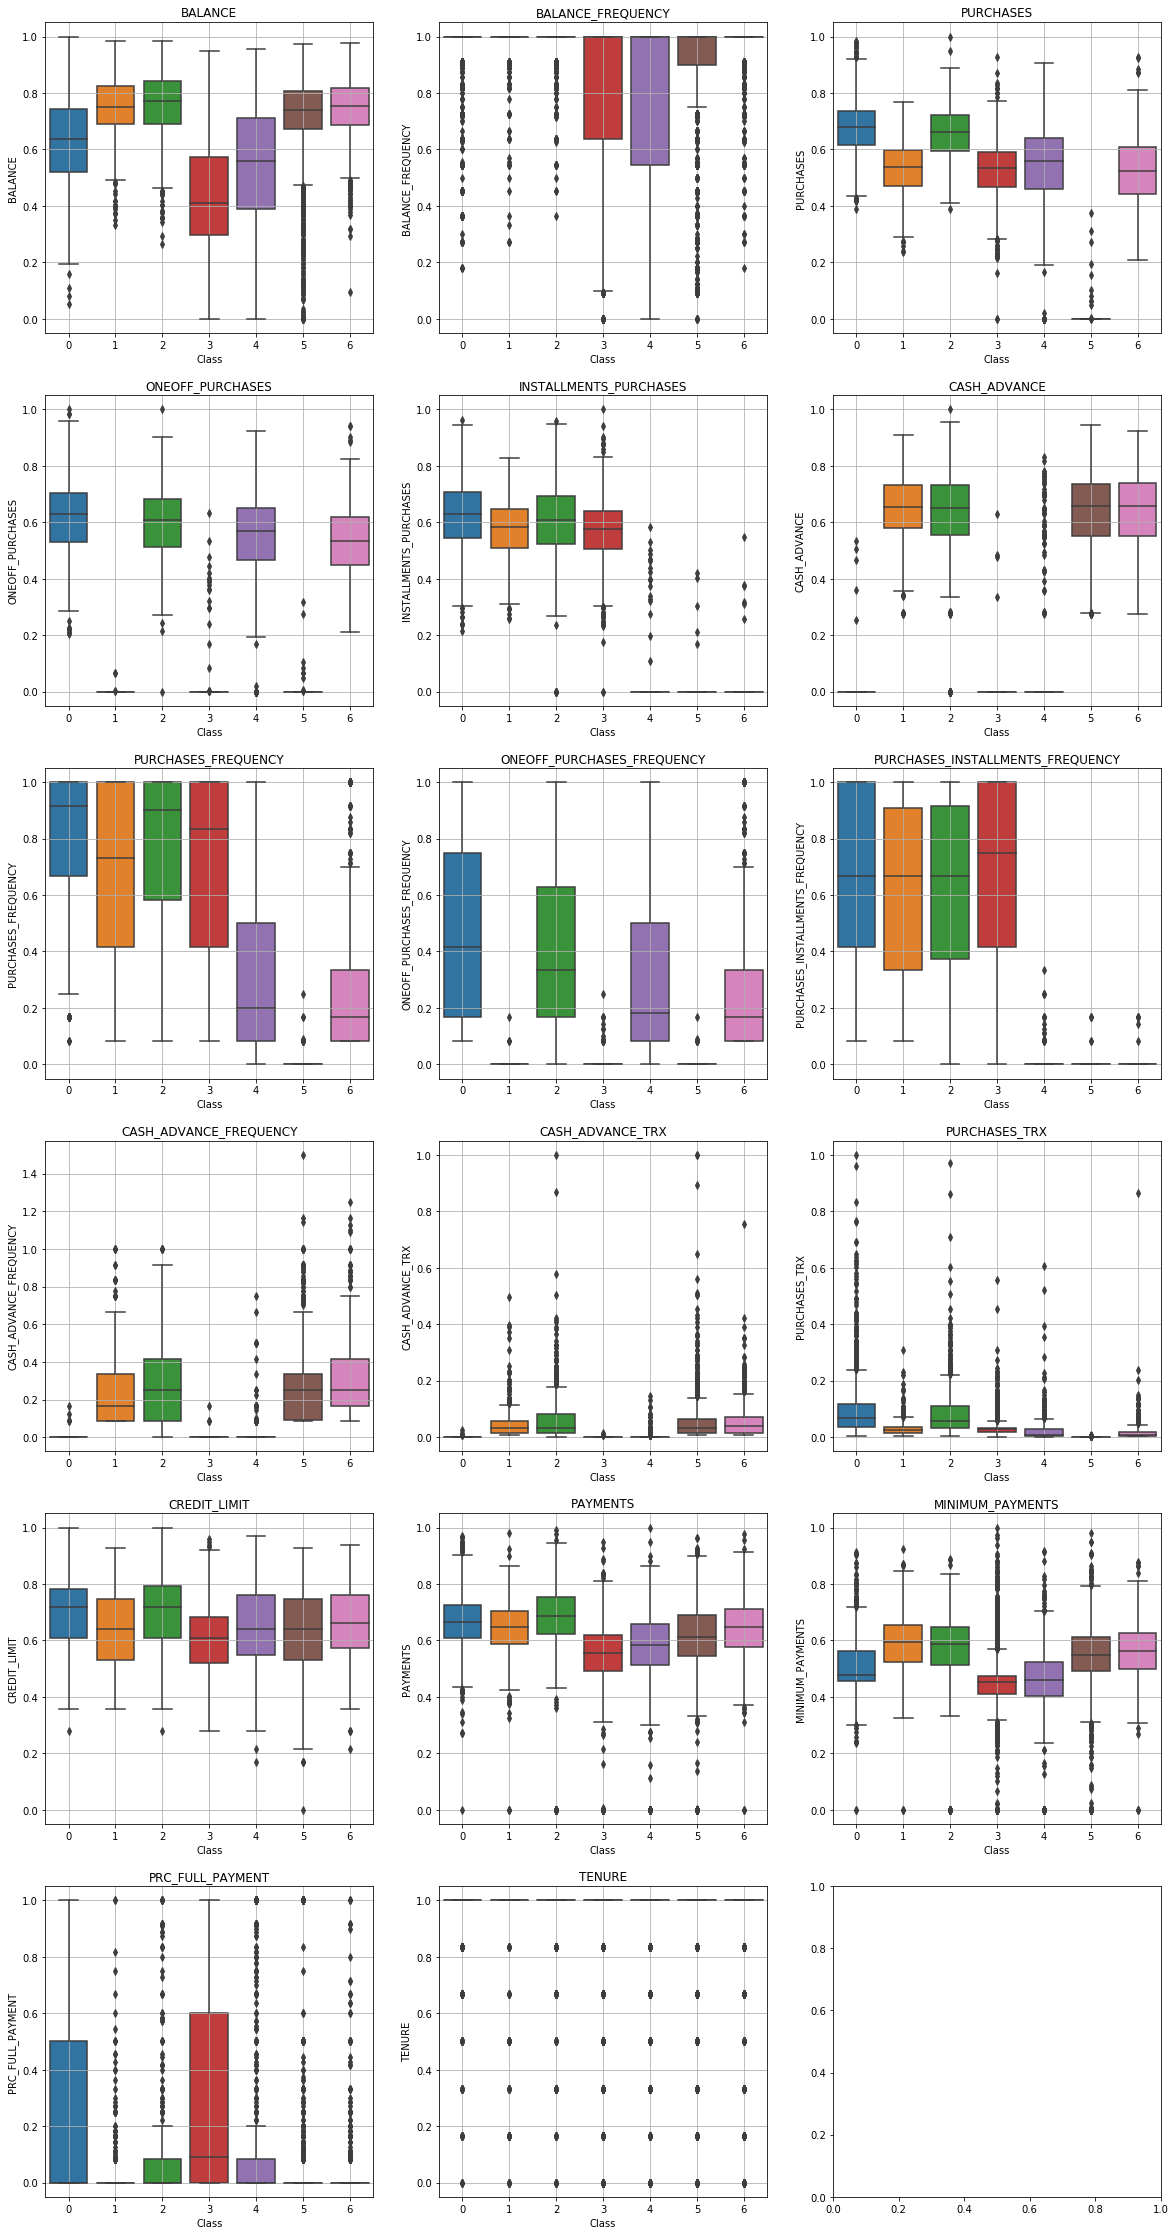

In [67]:
visualize_feature_boxplot_for_clusters(data_df, labels)

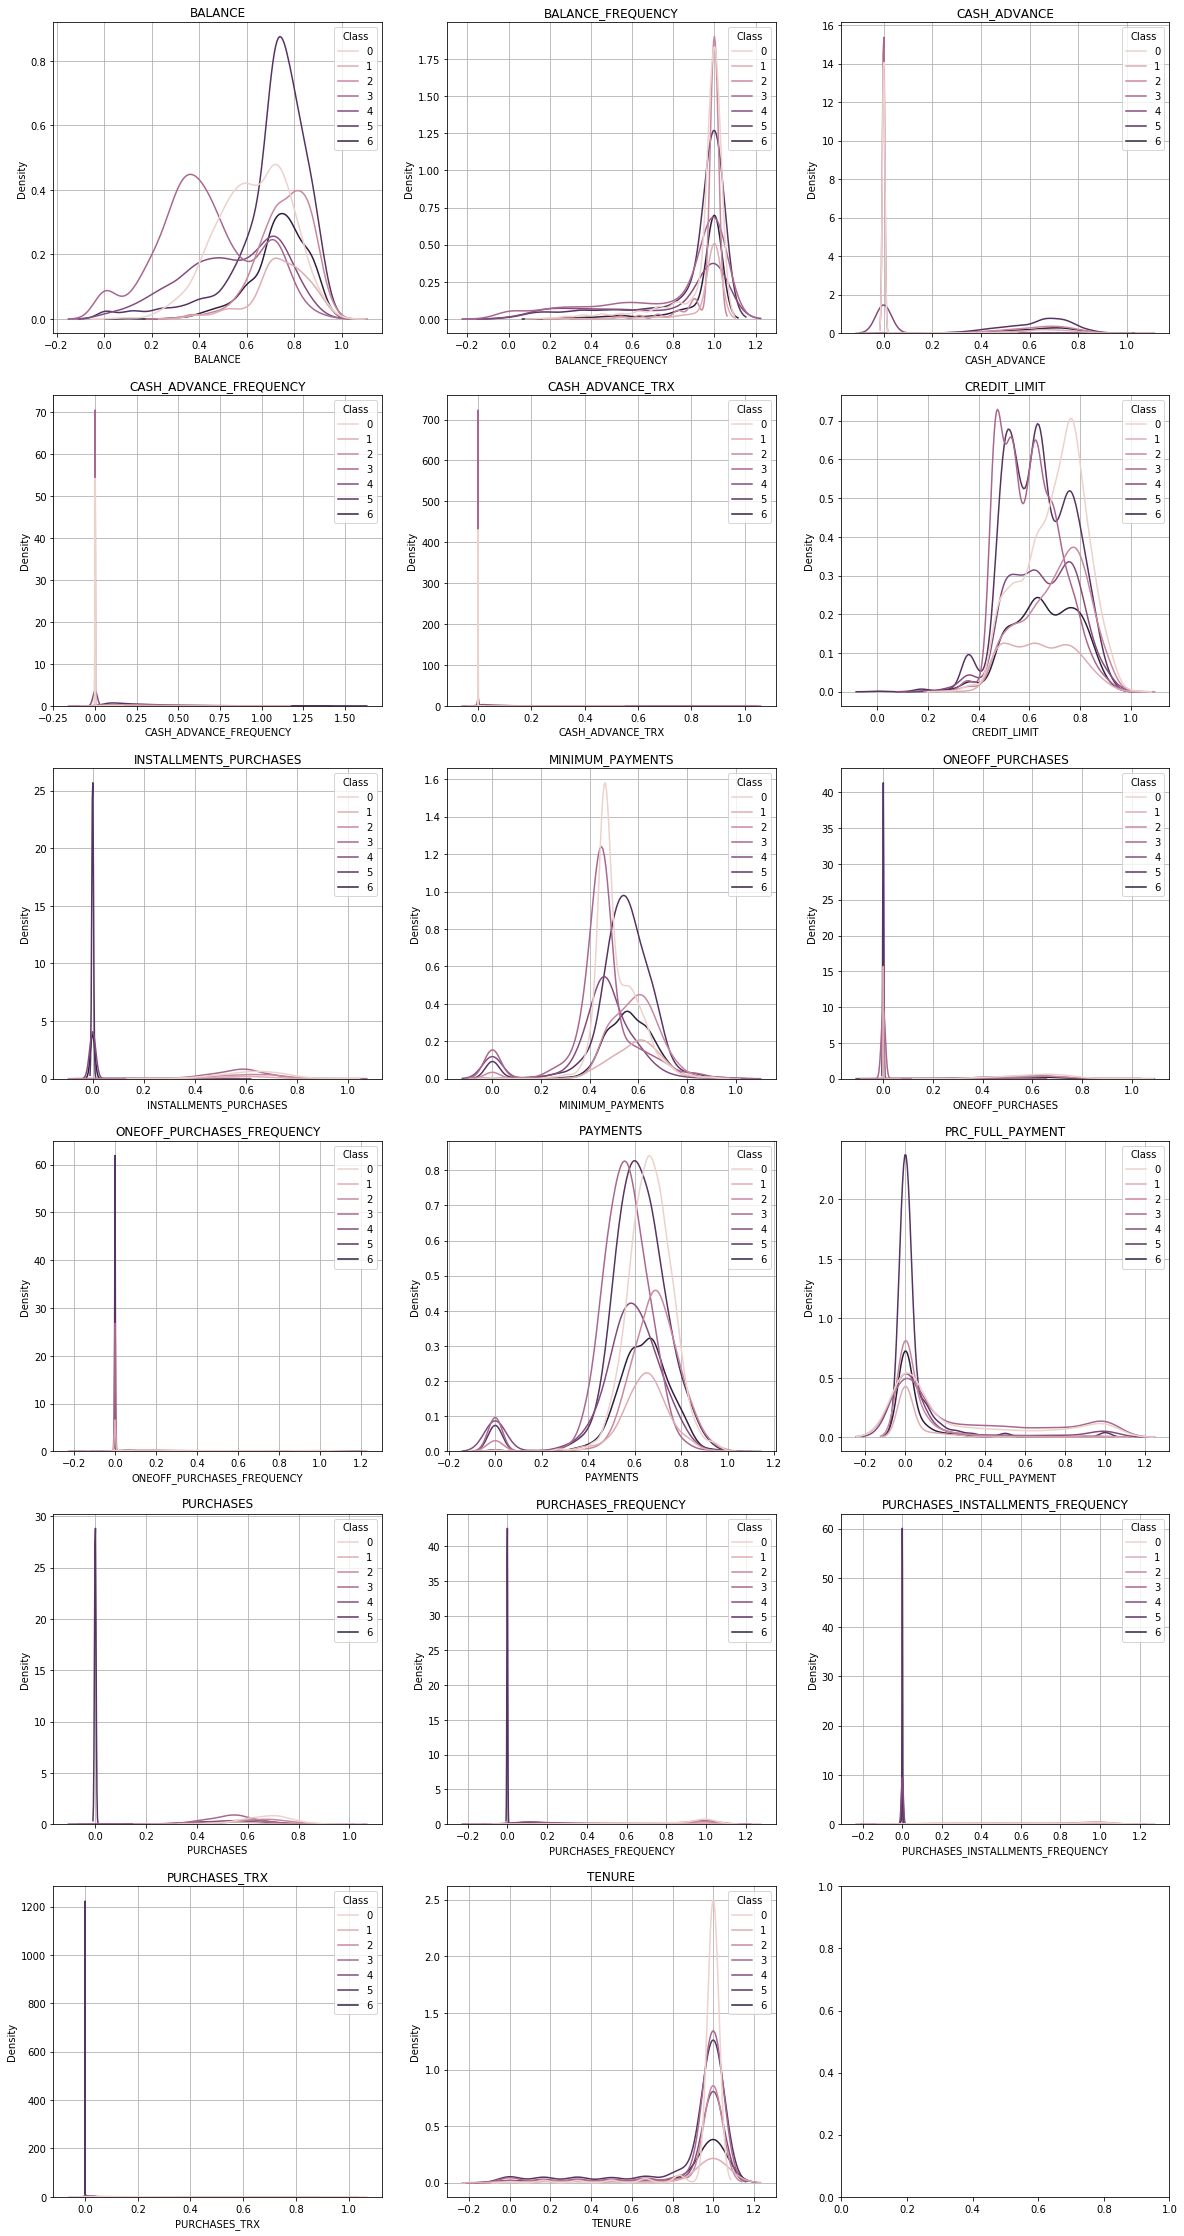

In [84]:
visualize_feature_distrib_for_clusters(data_df, labels)

## Choosing different K-Means clusters

In [85]:
def kmeans_clustering(X, num_clusters_to_try):
    """
        X is numpy array or pandas dataframe with num-samples X num-features
        num_clusters_to_try are the values of K to use
        returns an array of labels for each sample.
    """
    N = len(num_clusters_to_try)
    avg_silhouette = np.zeros([N, ])
    differences_labels = np.zeros([np.shape(X)[0], N])
    for ii, nn in enumerate(num_clusters_to_try):
        kmeans_clusterer = KMeans(n_clusters=nn)
        differences_labels[:, ii] = kmeans_clusterer.fit_predict(X)
        avg_silhouette[ii] = silhouette_score(X, differences_labels[:, ii].flatten())
    chosen_cluster = np.argmax(avg_silhouette)
    print('silhouette scores are '+str(avg_silhouette))
    print('chosen cluster is ' + str(num_clusters_to_try[chosen_cluster]))
    return differences_labels[:, chosen_cluster].flatten().astype(int)

In [ ]:
# Doing PCA if required
# # Do PCA to reduce number of dimensions
# pca = PCA(n_components=9)
# principal_components = pca.fit_transform(data_norm_np)
# print('Explained Variance is %1.2f'%(np.sum(pca.explained_variance_ratio_)))

silhouette scores are [0.43719211 0.56390148 0.63841832 0.69367176 0.72862107 0.7478776 ]
chosen cluster is 7


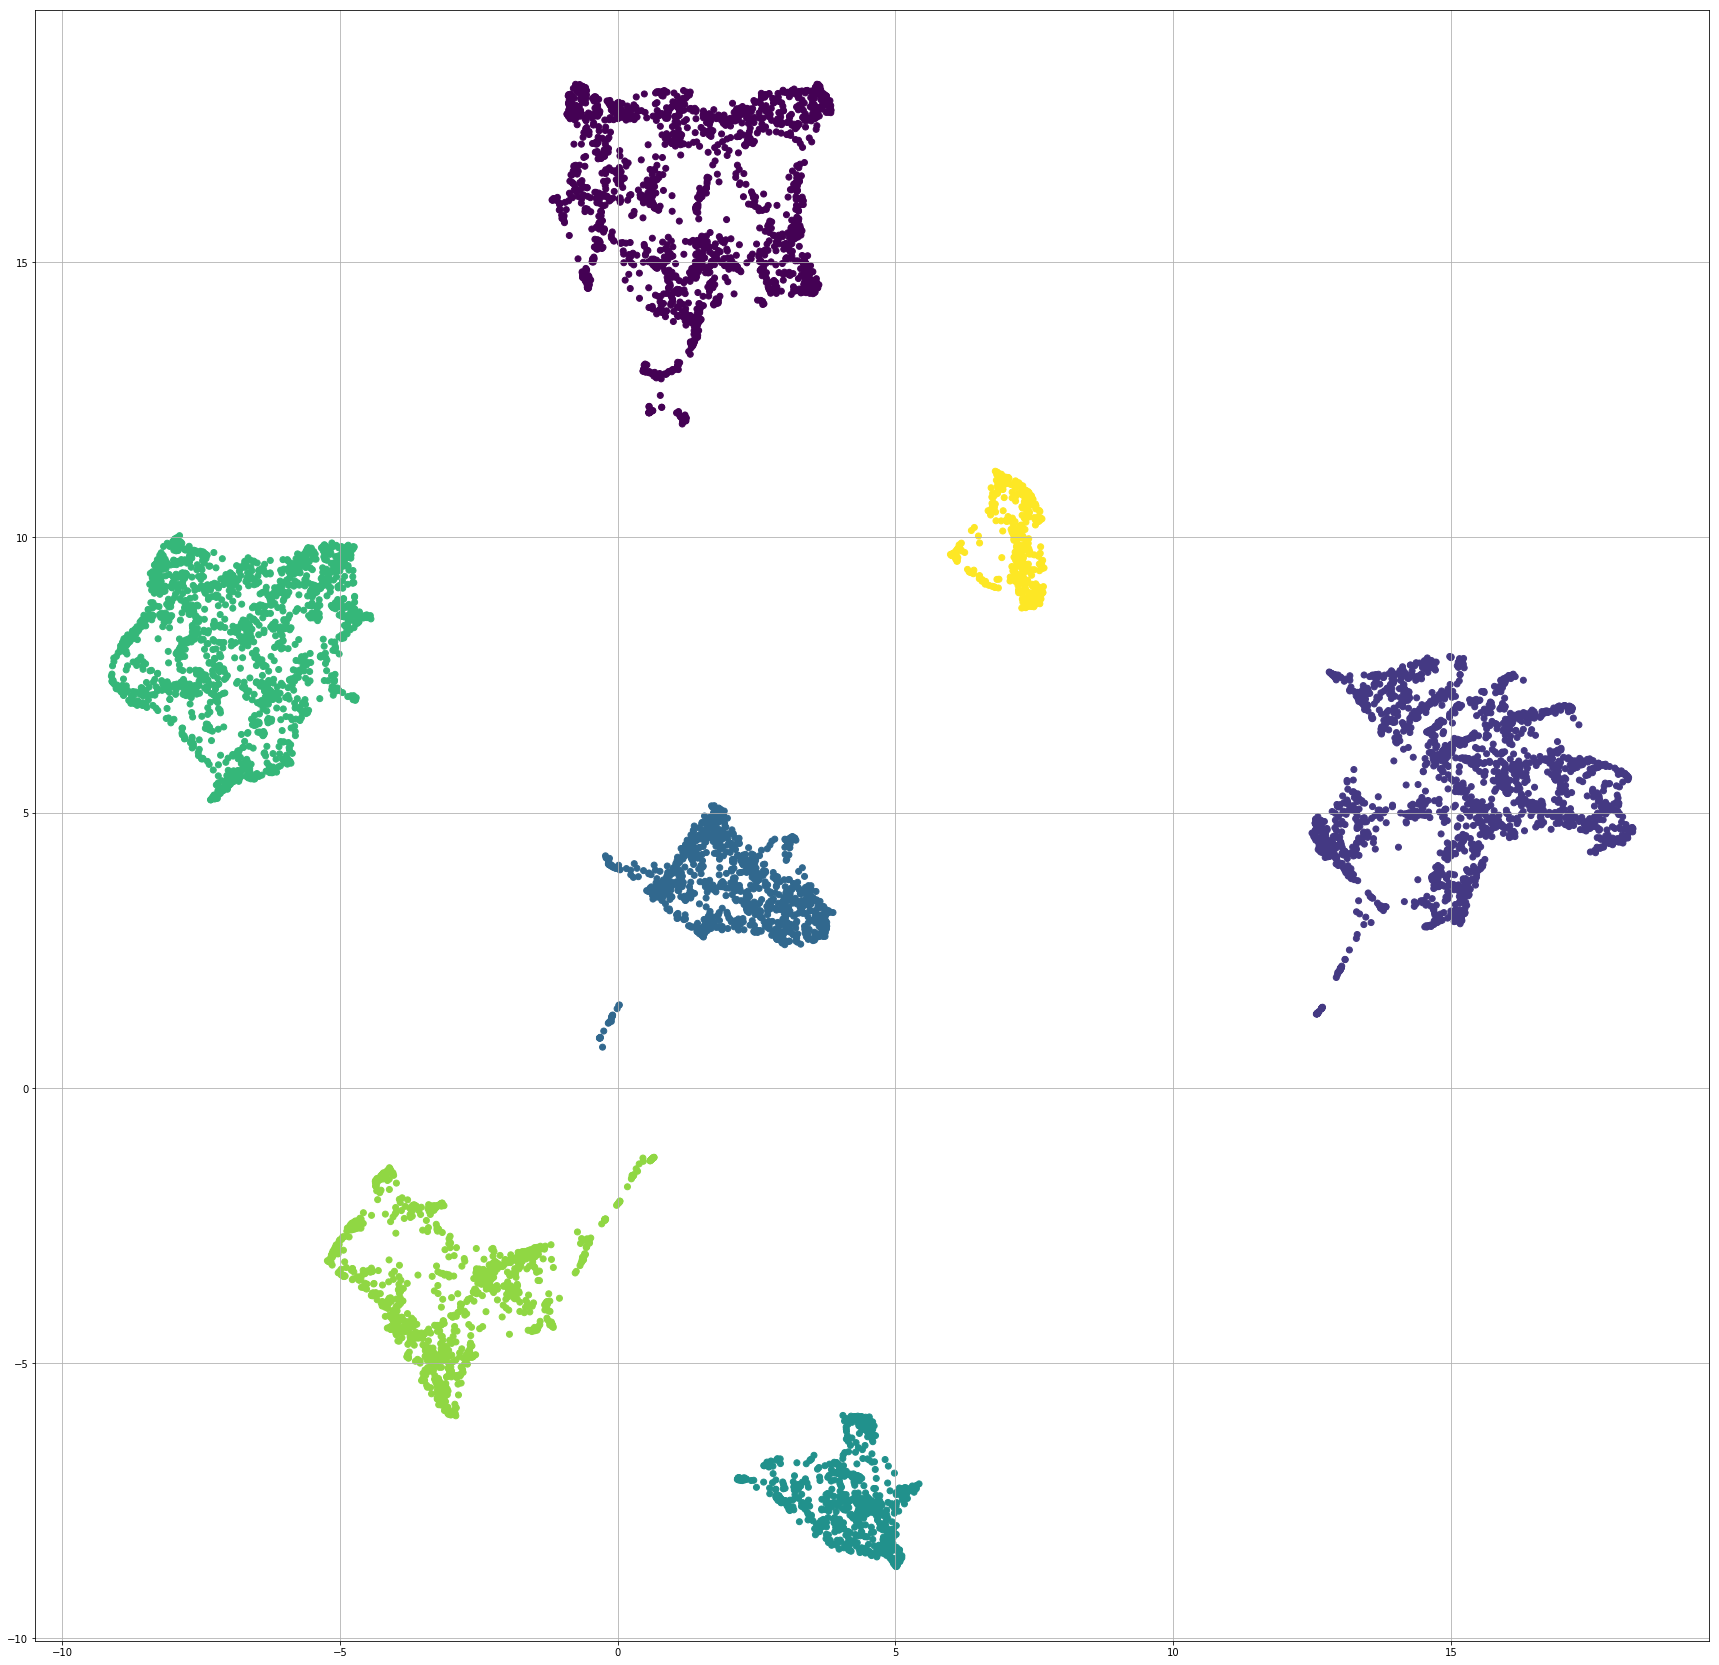

In [88]:
cluster_labels = kmeans_clustering(embedding, np.arange(2,8))


plt.figure()
plt.scatter(embedding[:, 0],  embedding[:, 1], c = cluster_labels)
plt.grid(b=True)
plt.show()